# Project Description

**This project aims to apply the task of Named Entity Recognition to the Romanian language. The method proposed uses the pre-trained Bert Base Multilingual Cased.**

[RONEC](https://github.com/dumitrescustefan/ronec) is the dataset used for fine tuning. It is a free corpus that holds 5127 sentences, annotated with 16 classes, with a total of 26376 annotated entities. The dataset is annotated using BIO-schema. 

From the existing files in this repository, we will use *ronec_iob.conllup*.

# Requestment

In [ ]:
pip install transformers

In [ ]:
pip install seqeval

# Convert to CSV file

Before starting to process the dataset, we have to adapt it to our algorithm. First, we remove the header of the file content, then the sub-headers of each sentence. Finally, we remove the empty lines.

*NOTE: If this file is uploaded to Google Colab, its location must be the root folder.*

In [4]:
!sed -i '/^# global.columns/d' /ronec_iob.conllup

In [5]:
!sed -i '/^# text/d' /ronec_iob.conllup

In [6]:
!sed -i '/^# sent_id/d' /ronec_iob.conllup

In [7]:
!sed -i '/^$/d' /ronec_iob.conllup

Convert the file to CSV and keep only the relevant columns: the senetence number, the word and the label of the word.

In [8]:
import pandas as pd

In [10]:
data_raw = pd.read_csv("/ronec_iob.conllup", 
                       header=None, 
                       sep="\t", 
                       engine='python', 
                       usecols=[0, 1, 10])
data_raw.shape

(180467, 3)

In [11]:
sentence = []
word = []
tag = []
num = 1

for index, row in data_raw.iterrows():
    # Set the senetence number in the first column 
    # of the first word of the sentence.
    if row.values[0] == 1:
        sentence.append("Sentence: " + str(num))
        num = num + 1
    else:
        sentence.append(None)
    word.append(row.values[1])
    tag.append(row.values[2])

In [12]:
df = pd.DataFrame({'Sentence': sentence, 'Word': word, "Label": tag})
df.to_csv('/ronec.csv', index=False)

# Reading and Preprocessing

In [71]:
data = pd.read_csv("/ronec.csv").fillna(method="ffill")
data.tail(10)

,Sentence,Word,Label
180457,Sentence: 5217,care,O
180458,Sentence: 5217,s-,O
180459,Sentence: 5217,au,O
180460,Sentence: 5217,opus,O
180461,Sentence: 5217,intervenției,O
180462,Sentence: 5217,poliției,O
180463,Sentence: 5217,au,O
180464,Sentence: 5217,fost,O
180465,Sentence: 5217,arestate,O
180466,Sentence: 5217,.,O


In [72]:
class SentenceGetter(object):
    # Read the data and grouped it by sentences,
    def __init__(self, data):
        self.data = data
        agg_func = lambda s: [(w, t) 
          for w, t in zip(s["Word"].values.tolist(), s["Label"].values.tolist())]
        self.grouped = self.data.groupby("Sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [73]:
getter = SentenceGetter(data)

Below we extract the needed information from the dataset: sentences, labels of each sentences, set of labels and the mapping between labels and indexes.

In [74]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]

['Tot',
 'în',
 'cadrul',
 'etapei',
 'a',
 '2',
 '-a',
 ',',
 'a',
 'avut',
 'loc',
 'întâlnirea',
 'Vardar',
 'Skopje',
 '-',
 'S.C.',
 'Pick',
 'Szeged',
 ',',
 'care',
 's-',
 'a',
 'încheiat',
 'la',
 'egalitate',
 ',',
 '24',
 '-',
 '24',
 '.']

In [75]:
labels = [[word[1] for word in sentence] for sentence in getter.sentences]
labels[0]

['O',
 'O',
 'O',
 'O',
 'B-ORDINAL',
 'I-ORDINAL',
 'I-ORDINAL',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-ORGANIZATION',
 'I-ORGANIZATION',
 'O',
 'B-ORGANIZATION',
 'I-ORGANIZATION',
 'I-ORGANIZATION',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-NUMERIC_VALUE',
 'O',
 'B-NUMERIC_VALUE',
 'O']

The BERT model receives a fixed length of sentence as input. 

For sentences that are shorter than this maximum length, we will have to add paddings (empty tokens) to the sentences to make up the length. 

In the original implementation, the token **[PAD]** is used to represent paddings to the sentence.

In [76]:
label_set = list(set(data["Label"].values))
label_set.append("PAD")
label_set

['I-LANGUAGE',
 'I-GPE',
 'I-MONEY',
 'I-PRODUCT',
 'I-PERIOD',
 'I-ORDINAL',
 'B-DATETIME',
 'I-EVENT',
 'I-NAT_REL_POL',
 'B-NAT_REL_POL',
 'I-WORK_OF_ART',
 'B-ORDINAL',
 'B-PERIOD',
 'B-GPE',
 'I-FACILITY',
 'B-LANGUAGE',
 'B-QUANTITY',
 'B-NUMERIC_VALUE',
 'O',
 'B-LOC',
 'B-ORGANIZATION',
 'I-ORGANIZATION',
 'I-NUMERIC_VALUE',
 'I-LOC',
 'I-PERSON',
 'B-MONEY',
 'B-EVENT',
 'B-FACILITY',
 'B-WORK_OF_ART',
 'B-PRODUCT',
 'B-PERSON',
 'I-QUANTITY',
 'I-DATETIME',
 'PAD']

In [77]:
label2idx = {t: i for i, t in enumerate(label_set)}
label2idx

{'B-DATETIME': 6,
 'B-EVENT': 26,
 'B-FACILITY': 27,
 'B-GPE': 13,
 'B-LANGUAGE': 15,
 'B-LOC': 19,
 'B-MONEY': 25,
 'B-NAT_REL_POL': 9,
 'B-NUMERIC_VALUE': 17,
 'B-ORDINAL': 11,
 'B-ORGANIZATION': 20,
 'B-PERIOD': 12,
 'B-PERSON': 30,
 'B-PRODUCT': 29,
 'B-QUANTITY': 16,
 'B-WORK_OF_ART': 28,
 'I-DATETIME': 32,
 'I-EVENT': 7,
 'I-FACILITY': 14,
 'I-GPE': 1,
 'I-LANGUAGE': 0,
 'I-LOC': 23,
 'I-MONEY': 2,
 'I-NAT_REL_POL': 8,
 'I-NUMERIC_VALUE': 22,
 'I-ORDINAL': 5,
 'I-ORGANIZATION': 21,
 'I-PERIOD': 4,
 'I-PERSON': 24,
 'I-PRODUCT': 3,
 'I-QUANTITY': 31,
 'I-WORK_OF_ART': 10,
 'O': 18,
 'PAD': 33}

# Apply BERT

In [78]:
import torch
import transformers

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig, BertForTokenClassification, AdamW, get_linear_schedule_with_warmup
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

We will limit our sequence length to 100 tokens and we will use a batch size of 32 as suggested by the Bert paper. 

In [79]:
MAX_TOKEN_LEN = 100
BATCH_SIZE = 32

We will try to run the algorithm on CUDA if it is available.

In [80]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [81]:
torch.cuda.get_device_name(0)

'Tesla T4'

We load the Bert pretrained tokenizer related to the bert-base-multilingual-cased pre-trained model. 

In [82]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', 
                                          do_lower_case=False)

We tokenize all sentences.
In the following function, we first tokenize the word and count the number of subwords the word is broken into (because BERT used to do this). Then, we add the tokenized word to the final tokenized word list and, finally, add the same label to the new list of labels *n_subwords* times.

In [83]:
def tokenize_sentence(sentence, text_labels):
    _tokenized_sentence = []
    _labels = []

    for _word, _label in zip(sentence, text_labels):
        _tokenized_word = tokenizer.tokenize(_word)
        _n_subwords = len(_tokenized_word)

        _tokenized_sentence.extend(_tokenized_word)

        _labels.extend([_label] * _n_subwords)

    return _tokenized_sentence, _labels

In [84]:
tokenized_sentences_and_labels = [ tokenize_sentence(sent, labs) 
    for sent, labs in zip(sentences, labels)
]

In [85]:
tokenized_sentences = [token_label_pair[0] 
                   for token_label_pair in tokenized_sentences_and_labels]
labels = [token_label_pair[1] 
          for token_label_pair in tokenized_sentences_and_labels]

 We cut and pad the token and label sequences to our desired length.

In [86]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) 
                            for txt in tokenized_sentences],
                          maxlen=MAX_TOKEN_LEN, 
                          dtype="long", 
                          value=0.0,
                          truncating="post", 
                          padding="post")

In [87]:
tags = pad_sequences([[label2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_TOKEN_LEN, 
                     value=label2idx["PAD"], 
                     padding="post",
                     dtype="long", 
                     truncating="post")

We create a mask to ignore the padded elements in the sequences.

In [88]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

We split the dataset to use 80% for training and 20% for validation.

In [89]:
training_inputs, valid_inputs, training_labels, valid_labels  = train_test_split(
                      input_ids, tags,
                      random_state=2021, 
                      test_size=0.2)
training_masks, valid_masks, _, _ = train_test_split(attention_masks, 
                                             input_ids,
                                             random_state=2021, 
                                             test_size=0.2)

We create torch tensors.

In [90]:
training_inputs = torch.tensor(training_inputs)
valid_inputs = torch.tensor(valid_inputs)

training_labels = torch.tensor(training_labels)
valid_labels = torch.tensor(valid_labels)

training_masks = torch.tensor(training_masks)
valid_masks = torch.tensor(valid_masks)

We create the tarin and validation dataloaders.

In [91]:
train_data = TensorDataset(training_inputs, training_masks, training_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_data = TensorDataset(valid_inputs, valid_masks, valid_labels)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)

We defined the model from Bert pretrained multilingual model.

In [ ]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=len(label2idx),
    output_attentions = False,
    output_hidden_states = False
)

In [93]:
model.cuda();

We setup the parameters the model should update. We add weight_decay as regularization to the main weight matrices. 

In [110]:
full_fine_tuning = False
if full_fine_tuning:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer 
                    if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer 
                    if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]


We set the Adam Optimizer because it is the most used one.

In [111]:
optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [112]:
EPOCHS = 3
MAX_GRAD_NORM = 1.0

total_steps = len(train_dataloader) * EPOCHS

We create a scheduler to reduce the learning rate during the training process.

In [113]:
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Fit BERT for NER

In [114]:
import numpy as np

from tqdm import tqdm, trange
from seqeval.metrics import f1_score, accuracy_score

 We fine tune the model.

In [ ]:
loss_values, valid_loss_values, valid_accuracy_values, valid_f1_score_values = [], [], [], []

for _ in trange(EPOCHS, desc="Epoch"):

    # T R A I N I N G

    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # clear previously calculated gradients
        model.zero_grad()
        # forward pass
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        loss = outputs[0]
        # backward pass
        loss.backward()
        # keep the train loss
        total_loss += loss.item()
        # clip the norm of the gradient 
        # to prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), 
                                       max_norm=MAX_GRAD_NORM)
        # update parameters
        optimizer.step()
        # update the learning rate.
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))
    loss_values.append(avg_train_loss)

    # V A L I D A T I O N

    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []

    for batch in valid_dataloader:
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # skip the gradient computing,
        with torch.no_grad():
            # forward pass
            outputs = model(b_input_ids, 
                            token_type_ids=None,
                            attention_mask=b_input_mask, 
                            labels=b_labels)
        # move logits and labels to cpu
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # calculate the accuracy
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    pred_labels = [label_set[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) 
                                 if label_set[l_i] != "PAD"]
    valid_labels = [label_set[l_i] for l in true_labels
                                  for l_i in l 
                                  if label_set[l_i] != "PAD"]

    eval_loss = eval_loss / len(valid_dataloader)
    print("Validation loss: {}".format(eval_loss))
    valid_loss_values.append(eval_loss)

    valid_accuracy = accuracy_score(pred_labels, valid_labels)
    print("Validation Accuracy: {}".format(valid_accuracy))
    valid_accuracy_values.append(valid_accuracy)

    valid_f1_score = f1_score([pred_labels], [valid_labels])
    print("Validation F1-Score: {}".format(valid_f1_score))
    valid_f1_score_values.append(valid_f1_score)
    
    print()

# Plots

In [100]:
import matplotlib.pyplot as plt

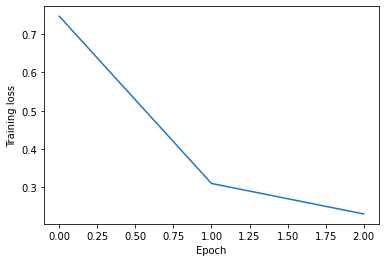

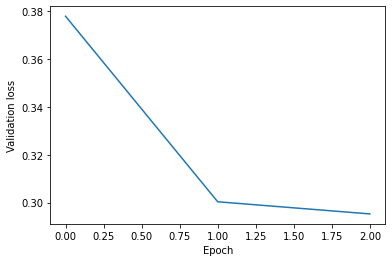

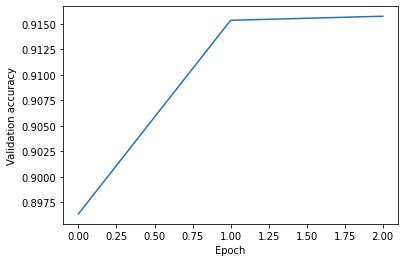

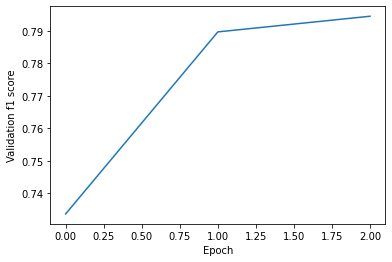

In [101]:
plt.plot(loss_values)
plt.ylabel('Training loss')
plt.xlabel('Epoch')
plt.show()

plt.plot(valid_loss_values)
plt.ylabel('Validation loss')
plt.xlabel('Epoch')
plt.show()

plt.plot(valid_accuracy_values)
plt.ylabel('Validation accuracy')
plt.xlabel('Epoch')
plt.show()

plt.plot(valid_f1_score_values)
plt.ylabel('Validation f1 score')
plt.xlabel('Epoch')
plt.show()

# Save the model

In [102]:
torch.save(model, '/model_fine_tuned')

saved_model = torch.load('/model_fine_tuned')

# Evaluation

In [104]:
sentence = """
Tudor Argezi s-a născut pe data de 21 mai 1880 la Bucureşti, în strada Ţărani nr. 46, numele său fiind Ion Nae Theodorescu. Este fiul lui Nae Theodorescu şi al Mariei Theodorescu. 
Între 1887 şi 1891 a fost elev al Şcolii primare „Petrache Poenaru”, sub îndrumarea primului său dascăl, Nicolae Abramescu. 
"""

We tokenize the test sentence.

In [105]:
tokenized_sentence = tokenizer.encode(sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

We predict the label indices.

In [106]:
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

We convert the indices to tokens.

In [107]:
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])

In [108]:
new_tokens, new_labels = [], []

for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        # the BERT model splits the words
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(label_set[label_idx])
        new_tokens.append(token)

In [109]:
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(token, label))

[CLS]	B-PERSON
Tudor	B-PERSON
Argezi	I-PERSON
s	O
-	O
a	O
născut	O
pe	O
data	O
de	O
21	B-DATETIME
mai	I-DATETIME
1880	I-DATETIME
la	O
Bucureşti	B-GPE
,	O
în	O
strada	B-LOC
Ţărani	I-LOC
nr	I-LOC
.	I-LOC
46	I-LOC
,	O
numele	O
său	O
fiind	O
Ion	B-PERSON
Nae	I-PERSON
Theodorescu	I-PERSON
.	O
Este	O
fiul	O
lui	O
Nae	B-PERSON
Theodorescu	I-PERSON
şi	O
al	O
Mariei	B-PERSON
Theodorescu	I-PERSON
.	O
Între	B-PERIOD
1887	I-PERIOD
şi	I-PERIOD
1891	I-PERIOD
a	O
fost	O
elev	B-PERSON
al	O
Şcolii	B-ORGANIZATION
primare	I-ORGANIZATION
„	I-ORGANIZATION
Petrache	I-ORGANIZATION
Poenaru	I-ORGANIZATION
[UNK]	I-ORGANIZATION
,	O
sub	O
îndrumarea	O
primului	B-ORDINAL
său	O
dascăl	B-PERSON
,	O
Nicolae	B-PERSON
Abramescu	I-PERSON
.	O
[SEP]	B-PERSON


# Application

Here is a screenshot from the application that uses the previoursly trained model.

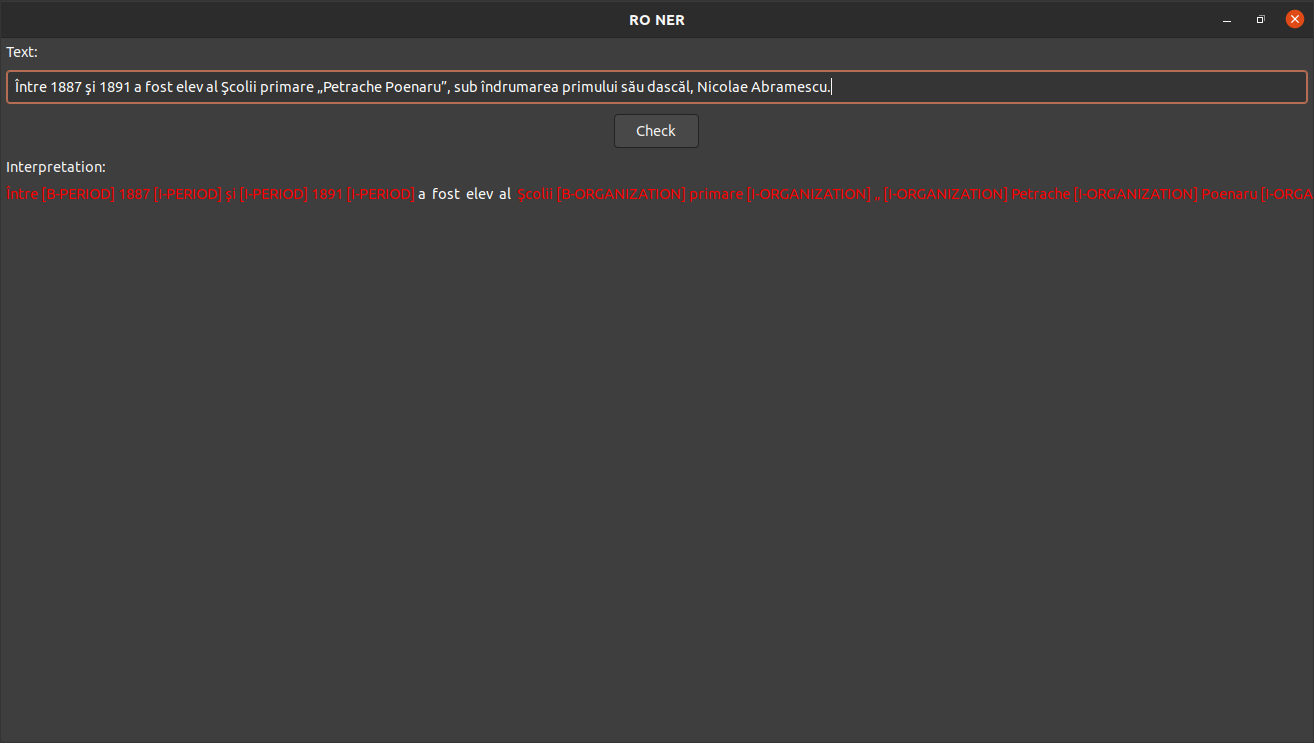